2025-06-09 18:45:38,802 - INFO - Connexion à MongoDB établie avec succès
2025-06-09 18:45:40,559 - INFO - Données chargées avec succès. 267468 enregistrements trouvés
2025-06-09 18:45:40,651 - INFO - Préparation des données réussie



VARIANCE EXPLIQUÉE PAR LES COMPOSANTES PRINCIPALES
PC1: 0.2830 (28.30%)
PC2: 0.1712 (17.12%)
PC3: 0.0964 (9.64%)
PC4: 0.0936 (9.36%)
PC5: 0.0848 (8.48%)
Variance cumulée: 0.7291 (72.91%)


2025-06-09 18:46:08,505 - INFO - Mise à jour réussie: 0 documents modifiés
2025-06-09 18:46:24,482 - INFO - Collection ACP créée: 267468 documents insérés


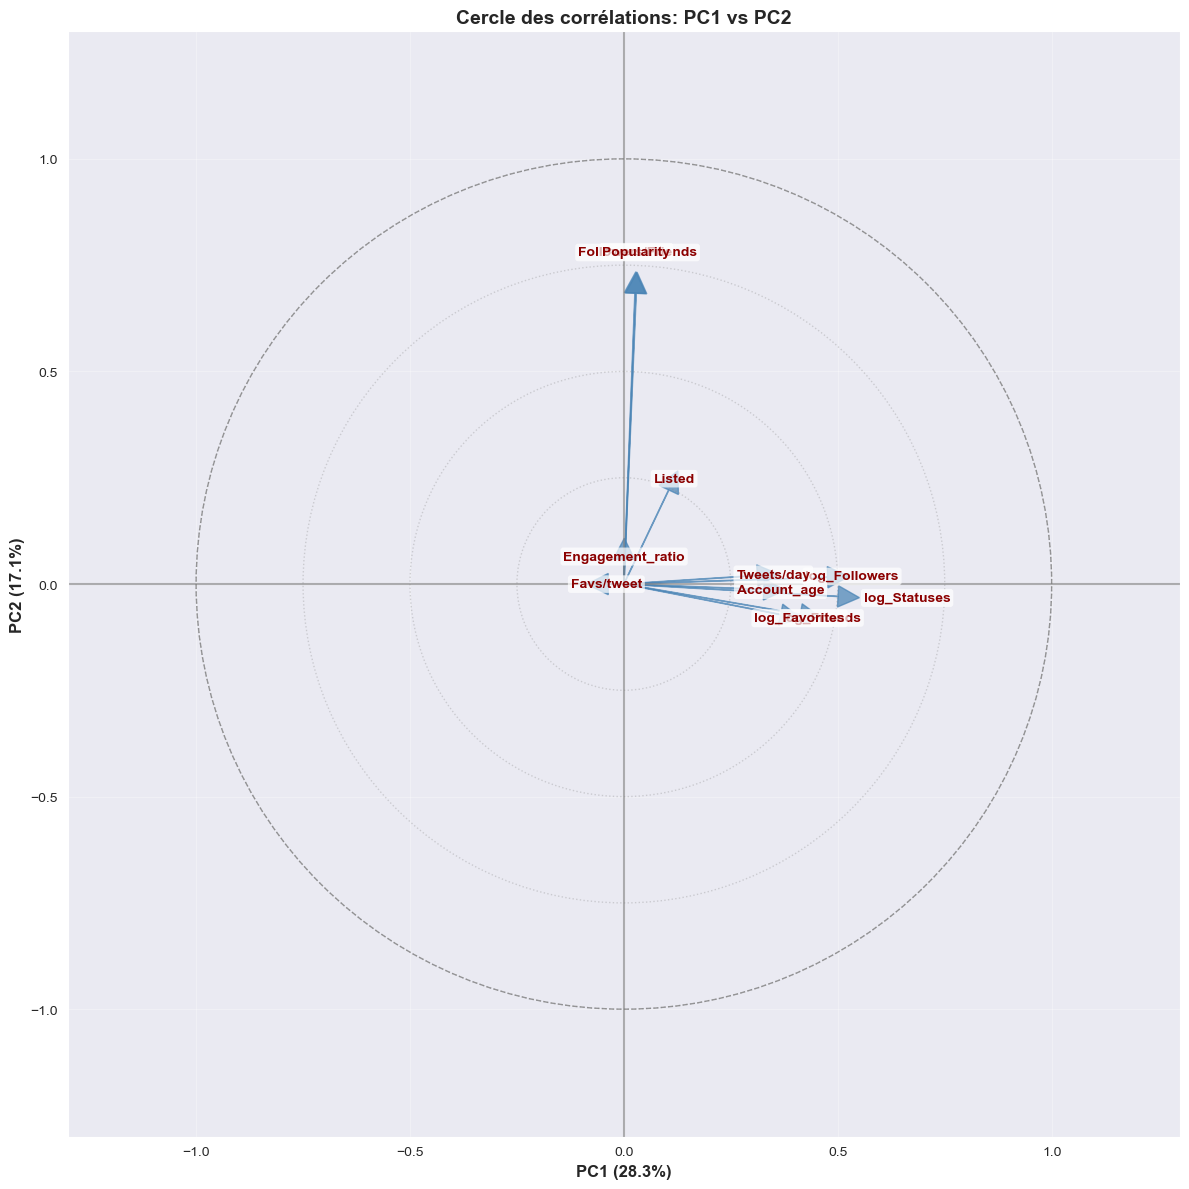

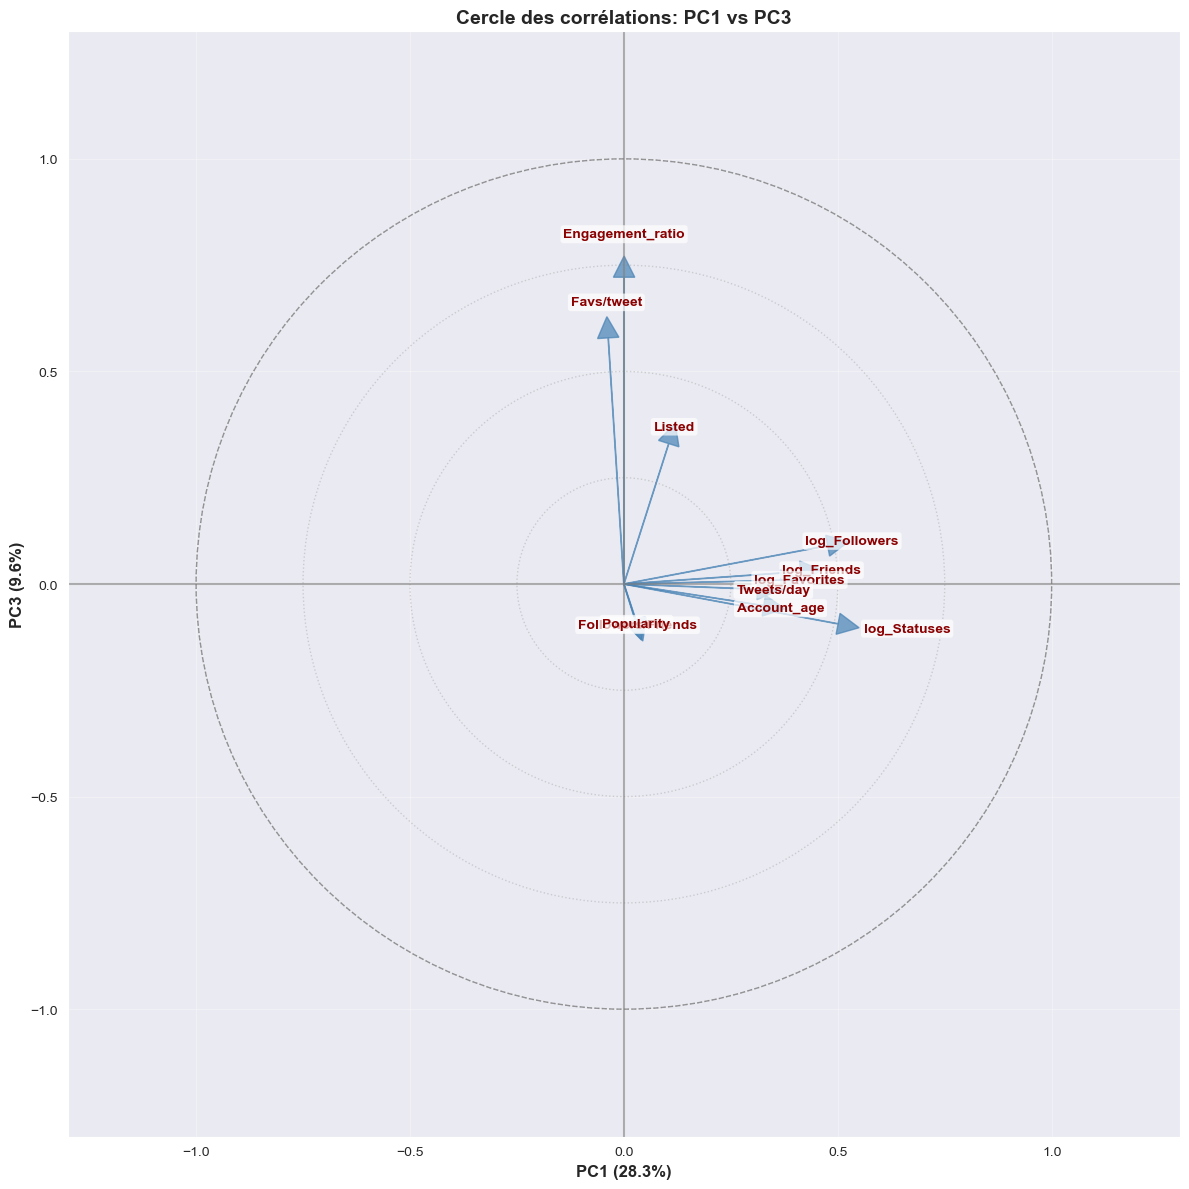

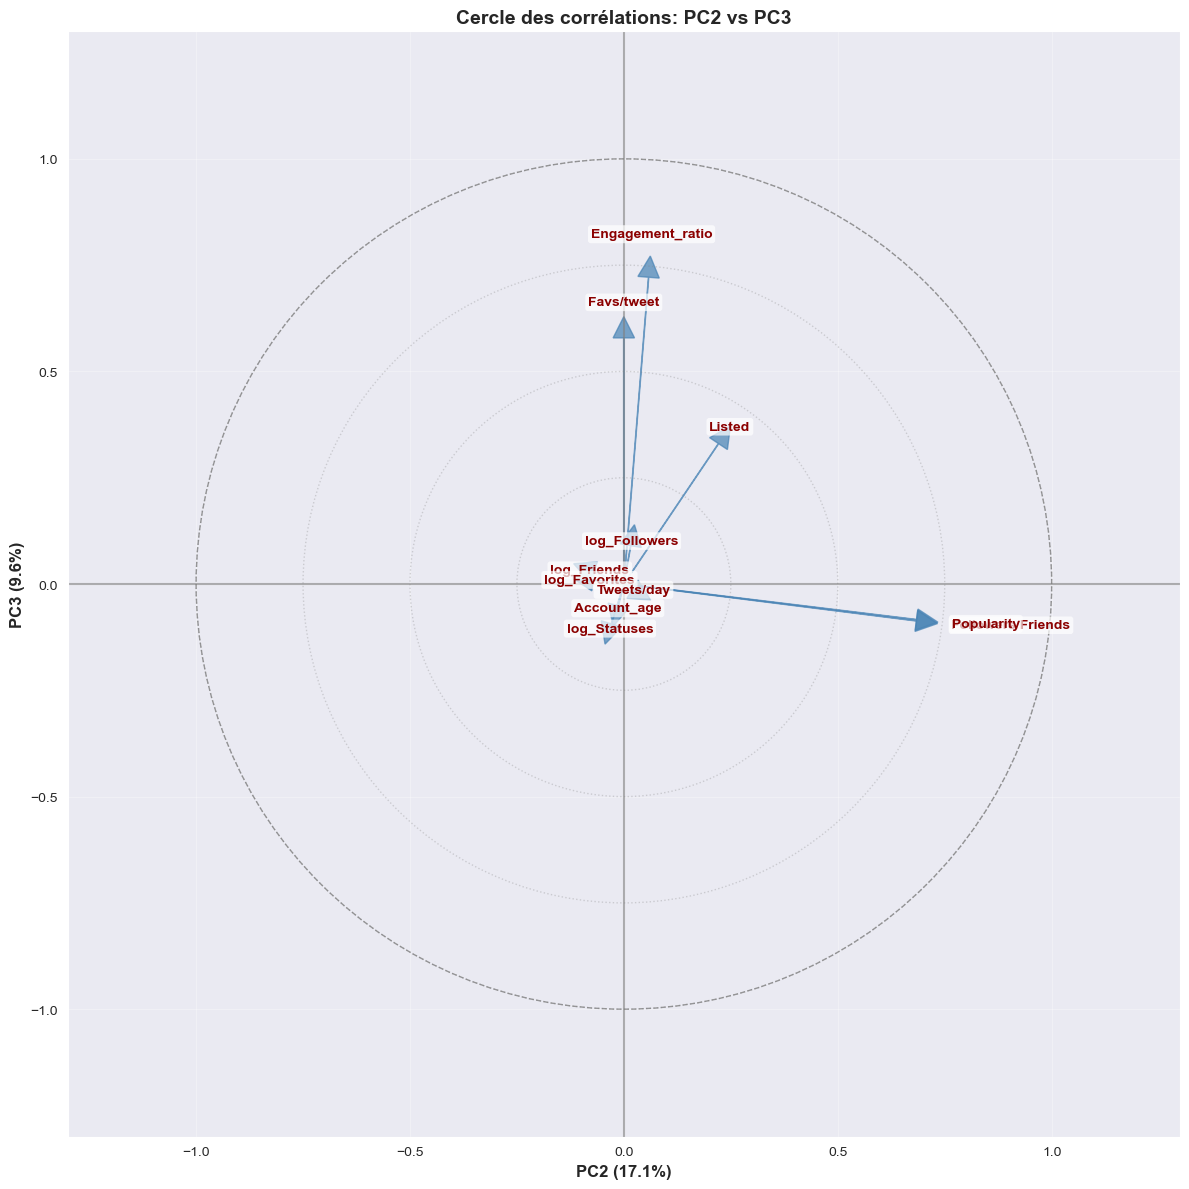

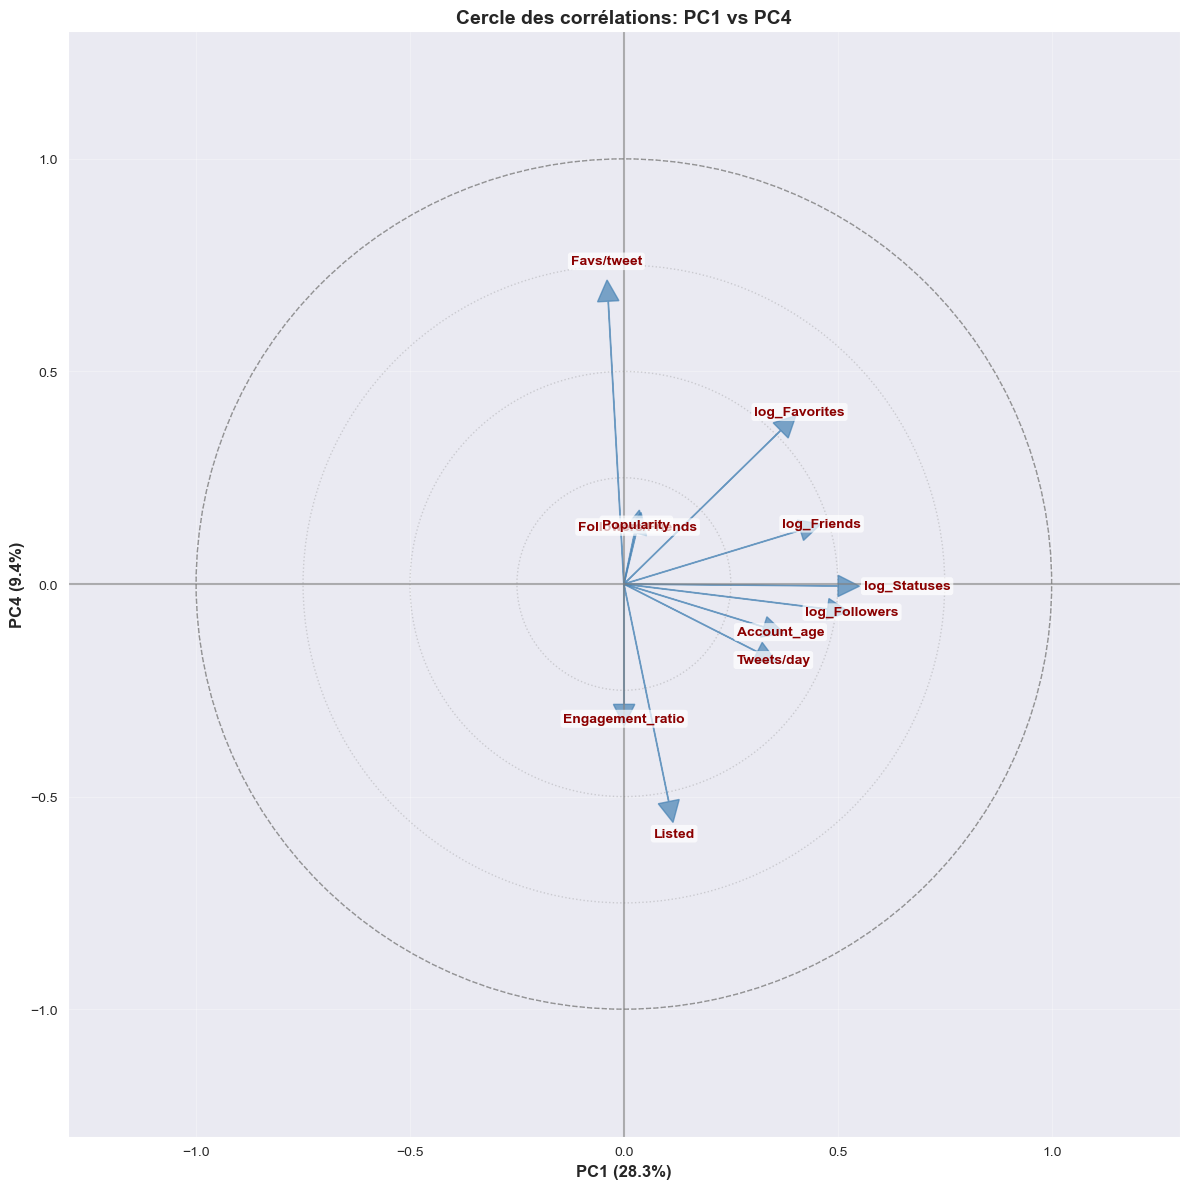

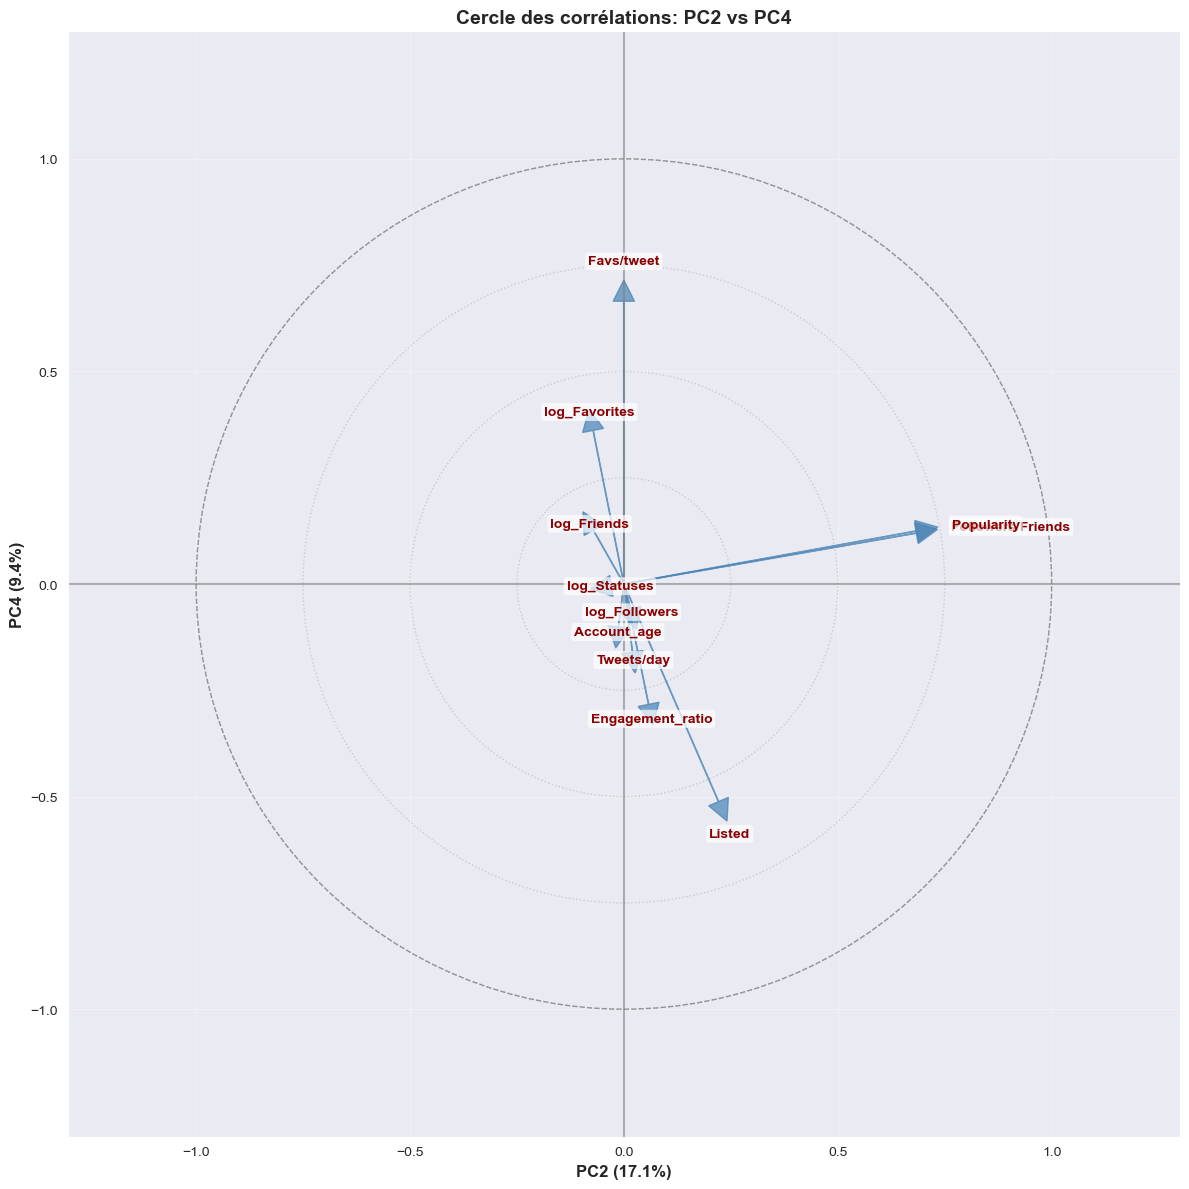

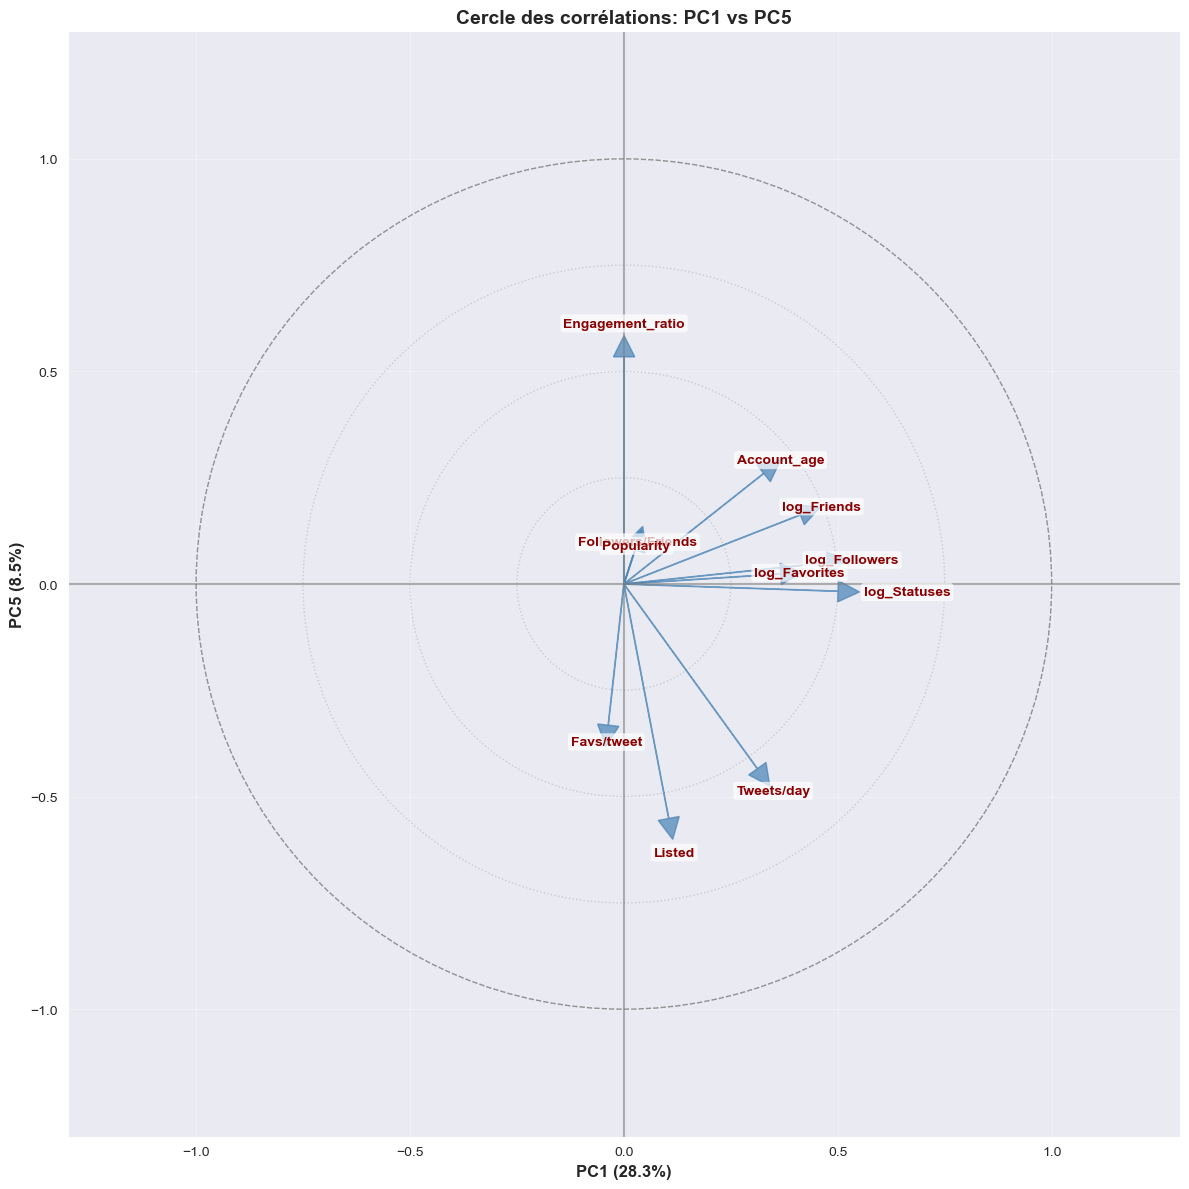

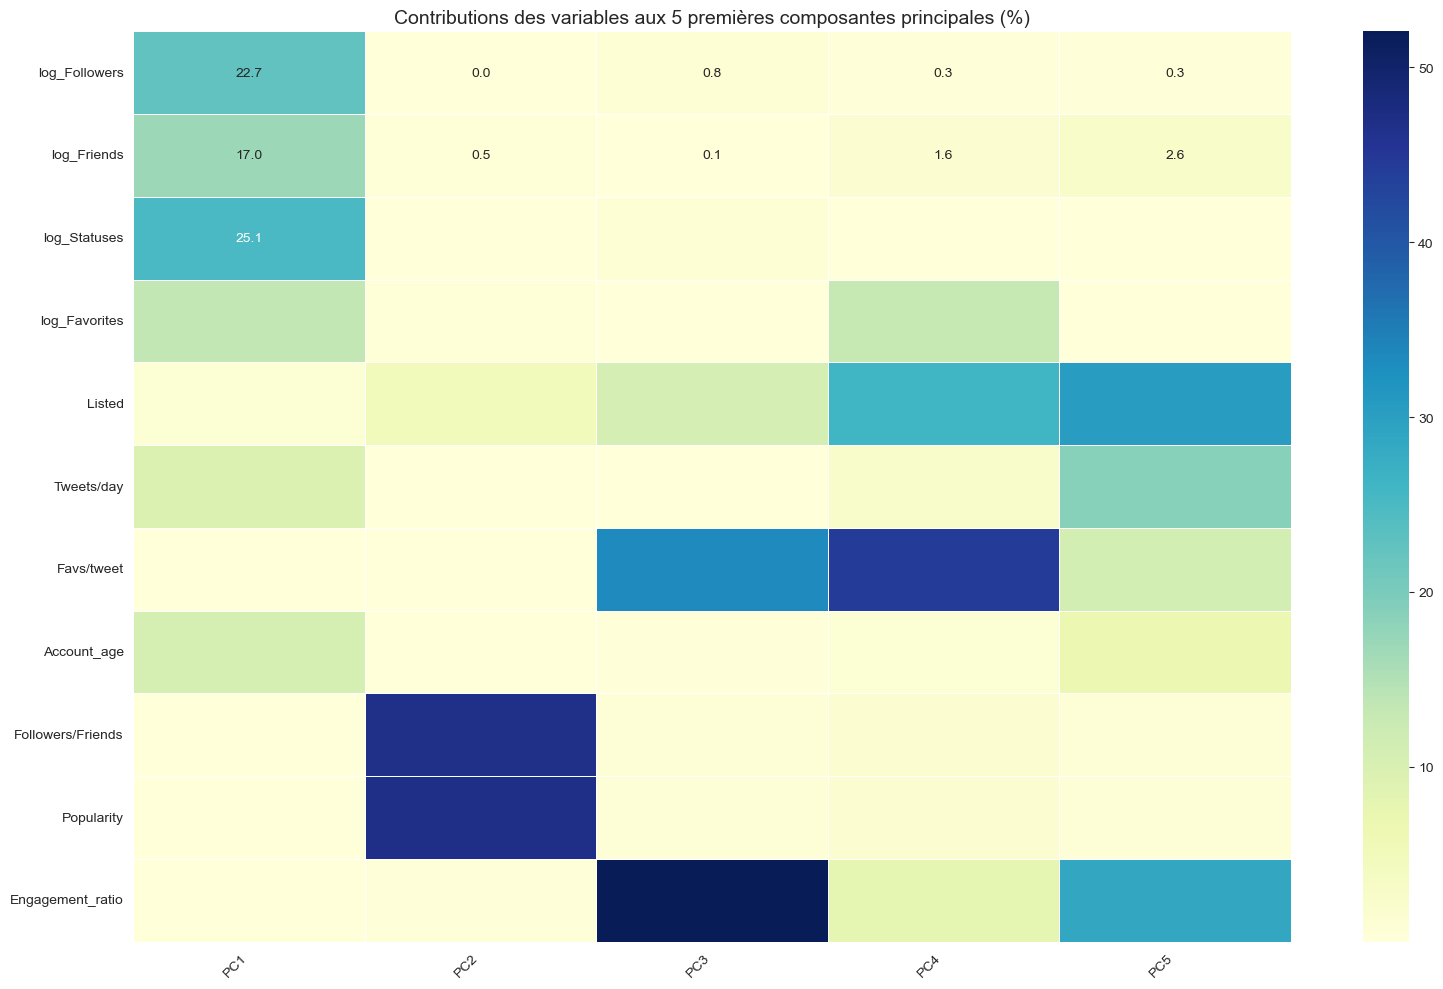

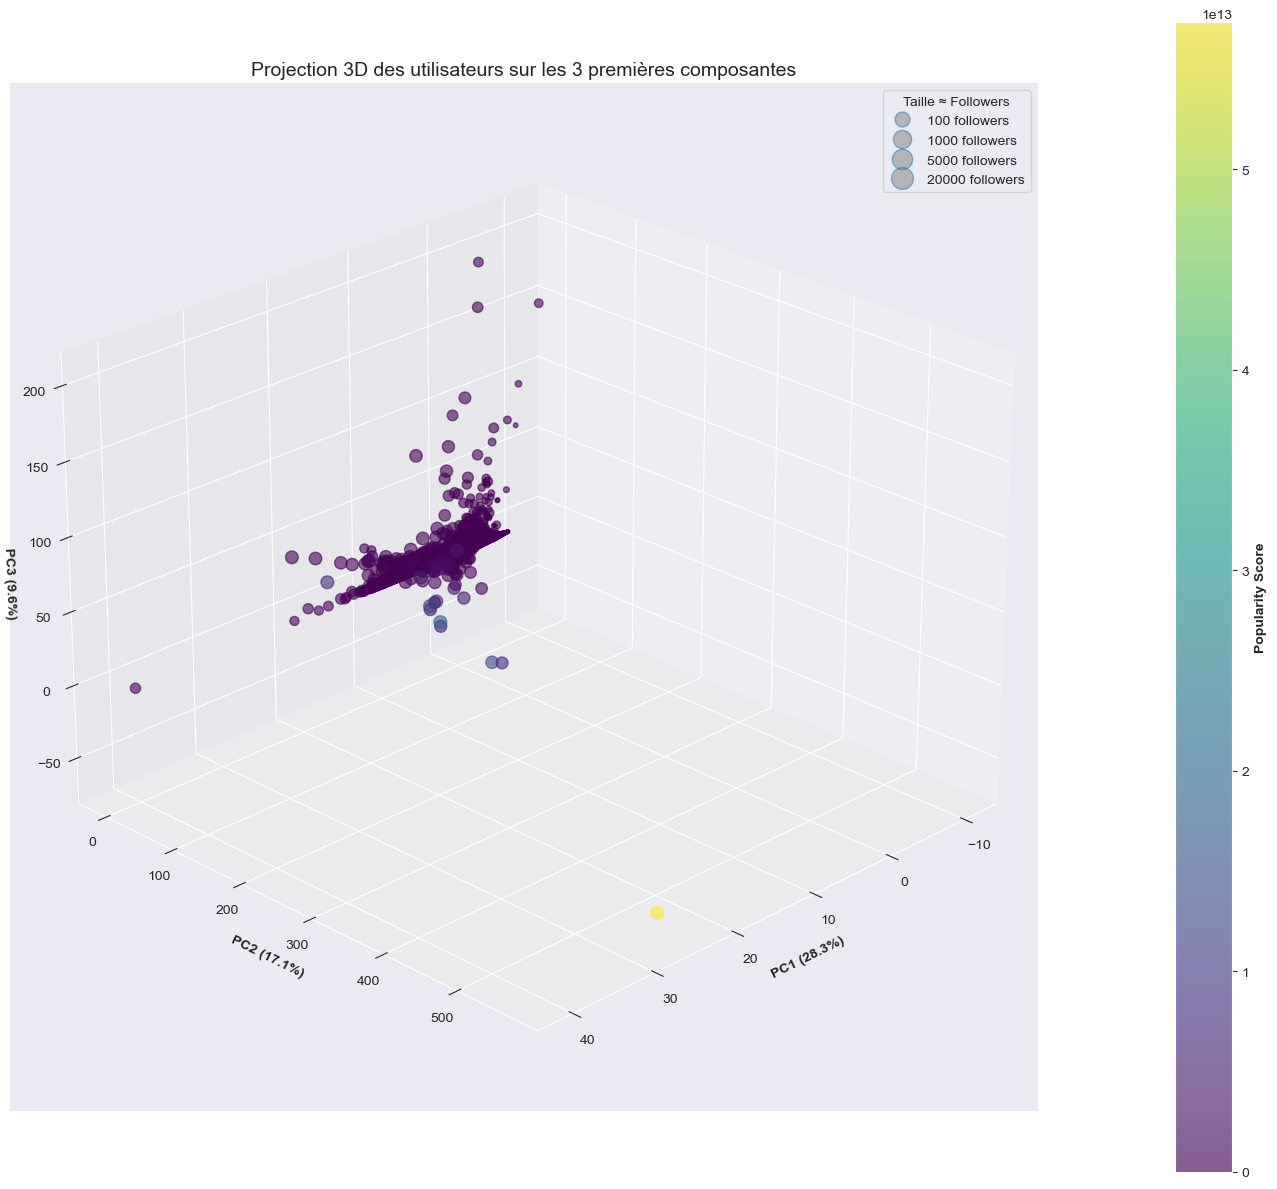

In [14]:
import pymongo
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.patches import Circle
import logging

# Configuration des logs
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')

# Connexion à MongoDB
try:
    client = pymongo.MongoClient("localhost", 27017)
    db = client["IF29_twitter_db"]
    collection = db["user_db"]
    logging.info("Connexion à MongoDB établie avec succès")
except Exception as e:
    logging.error(f"Erreur de connexion à MongoDB: {e}")
    raise

# Extraction des données avec sélection de variables optimisées ET ID
fields = {
    "_id": 1,
    "followers_count": 1,
    "friends_count": 1,
    "statuses_count": 1,
    "favourites_count": 1,
    "listed_count": 1,
    "tweets_per_day": 1,
    "favorites_per_tweet": 1,
    "account_age_days": 1,
    "followers_friends_ratio": 1,
    "popularity_score": 1
}

try:
    data = list(collection.find({}, fields))
    df = pd.DataFrame(data)
    logging.info(f"Données chargées avec succès. {len(df)} enregistrements trouvés")
except Exception as e:
    logging.error(f"Erreur lors du chargement des données: {e}")
    raise

# Nettoyage et préparation des données
def prepare_data(df):
    # Conversion forcée des colonnes en numérique
    numeric_cols = [
        'followers_count', 'friends_count', 'statuses_count', 'favourites_count',
        'listed_count', 'tweets_per_day', 'favorites_per_tweet', 'account_age_days',
        'followers_friends_ratio', 'popularity_score'
    ]
    
    for col in numeric_cols:
        if col in df.columns:
            df[col] = pd.to_numeric(df[col], errors='coerce')
    
    # Création de nouvelles variables
    df['engagement_ratio'] = df['followers_count'] / (df['statuses_count'] + 1e-5)
    
    # Transformation logarithmique pour gérer la skewness
    skewed_cols = ['followers_count', 'friends_count', 'statuses_count', 'favourites_count']
    for col in skewed_cols:
        log_col = f'log_{col}'
        df[log_col] = np.log1p(df[col])
    
    # Gestion des valeurs manquantes
    numeric_only = df.select_dtypes(include=[np.number])
    df.fillna(numeric_only.mean(), inplace=True)
    
    # Sélection des caractéristiques finales
    features = [
        'log_followers_count', 
        'log_friends_count',
        'log_statuses_count',
        'log_favourites_count',
        'listed_count',
        'tweets_per_day',
        'favorites_per_tweet',
        'account_age_days',
        'followers_friends_ratio',
        'popularity_score',
        'engagement_ratio'
    ]
    
    return df, features

try:
    df, selected_features = prepare_data(df.copy())
    logging.info("Préparation des données réussie")
except Exception as e:
    logging.error(f"Erreur lors de la préparation des données: {e}")
    raise

# Vérification que l'ID n'est pas dans les features
if '_id' in selected_features:
    selected_features.remove('_id')
    logging.warning("'_id' retiré des features pour l'ACP")

# Standardisation des données (UNIQUEMENT sur les features sélectionnées)
scaler = StandardScaler()
X = df[selected_features]
X_scaled = scaler.fit_transform(X)

# ACP avec 5 composantes
pca = PCA(n_components=5)
df_pca = pca.fit_transform(X_scaled)

# Analyse des résultats
explained_variance = pca.explained_variance_ratio_
cumulative_variance = np.cumsum(explained_variance)

# Affichage de la variance expliquée
print("\n" + "="*50)
print("VARIANCE EXPLIQUÉE PAR LES COMPOSANTES PRINCIPALES")
print("="*50)
for i in range(5):
    print(f"PC{i+1}: {explained_variance[i]:.4f} ({explained_variance[i]*100:.2f}%)")
print(f"Variance cumulée: {cumulative_variance[4]:.4f} ({cumulative_variance[4]*100:.2f}%)")
print("="*50 + "\n")

# =============================================================================
# 1. SAUVEGARDE DES NOUVEAUX ATTRIBUTS DANS user_db
# =============================================================================
try:
    # Préparation des opérations de mise à jour
    update_operations = []
    
    for _, row in df.iterrows():
        update_data = {
            "engagement_ratio": float(row.get("engagement_ratio", 0)),
            "log_followers_count": float(row.get("log_followers_count", 0)),
            "log_friends_count": float(row.get("log_friends_count", 0)),
            "log_statuses_count": float(row.get("log_statuses_count", 0)),
            "log_favourites_count": float(row.get("log_favourites_count", 0)),
        }
        
        update_operations.append(
            pymongo.UpdateOne(
                {"_id": row["_id"]},
                {"$set": update_data}
            )
        )
    
    # Exécution par lots
    if update_operations:
        result = collection.bulk_write(update_operations)
        logging.info(f"Mise à jour réussie: {result.modified_count} documents modifiés")
    else:
        logging.warning("Aucune opération de mise à jour à effectuer")

except Exception as e:
    logging.error(f"Erreur lors de la mise à jour des documents: {e}")

# =============================================================================
# 2. CRÉATION DE LA COLLECTION ACP (version épurée)
# =============================================================================
try:
    # Préparation des données ACP
    acp_collection = db["acp_db"]
    acp_data = []
    
    for i, row in df.iterrows():
        acp_record = {
            "user_id": row["_id"],
            "PC1": float(df_pca[i, 0]),
            "PC2": float(df_pca[i, 1]),
            "PC3": float(df_pca[i, 2]),
            "PC4": float(df_pca[i, 3]),
            "PC5": float(df_pca[i, 4])
        }
        acp_data.append(acp_record)
    
    # Insertion dans la nouvelle collection
    if acp_data:
        acp_collection.delete_many({})
        result = acp_collection.insert_many(acp_data)
        logging.info(f"Collection ACP créée: {len(result.inserted_ids)} documents insérés")
    else:
        logging.warning("Aucune donnée ACP à insérer")

except Exception as e:
    logging.error(f"Erreur lors de la création de la collection ACP: {e}")


# Fonction de visualisation améliorée
def enhanced_correlation_circle(pca, features, x=0, y=1, figsize=(12, 12)):
    fig, ax = plt.subplots(figsize=figsize)
    
    # Cercle unité
    circle = Circle((0, 0), 1, color='gray', fill=False, linestyle='--', alpha=0.8)
    ax.add_patch(circle)
    
    # Flèches et labels
    for i, feature in enumerate(features):
        ax.arrow(0, 0, 
                pca.components_[x, i], 
                pca.components_[y, i], 
                head_width=0.05,
                head_length=0.05, 
                fc='steelblue', 
                ec='steelblue',
                alpha=0.7)
        
        # Position intelligente pour éviter les chevauchements
        offset = 1.12
        x_pos = pca.components_[x, i] * offset
        y_pos = pca.components_[y, i] * offset
        
        # Ajustement pour les labels opposés
        ha = 'center'
        va = 'center'
        if abs(pca.components_[x, i]) > 0.5:
            ha = 'left' if pca.components_[x, i] > 0 else 'right'
        if abs(pca.components_[y, i]) > 0.5:
            va = 'bottom' if pca.components_[y, i] > 0 else 'top'
        
        plt.text(x_pos, y_pos, feature,
                color='darkred',
                ha=ha,
                va=va,
                fontsize=10,
                fontweight='bold',
                bbox=dict(facecolor='white', alpha=0.7, edgecolor='none', boxstyle='round,pad=0.2'))
    
    # Lignes d'axe
    plt.axhline(0, color='grey', alpha=0.6, linestyle='-')
    plt.axvline(0, color='grey', alpha=0.6, linestyle='-')
    
    # Configuration
    plt.xlim(-1.3, 1.3)
    plt.ylim(-1.3, 1.3)
    plt.grid(True, alpha=0.3)
    plt.xlabel(f"PC{x+1} ({explained_variance[x]*100:.1f}%)", fontsize=12, fontweight='bold')
    plt.ylabel(f"PC{y+1} ({explained_variance[y]*100:.1f}%)", fontsize=12, fontweight='bold')
    plt.title(f"Cercle des corrélations: PC{x+1} vs PC{y+1}", fontsize=14, fontweight='bold')
    
    # Ajouter la grille circulaire
    for r in np.arange(0.25, 1.25, 0.25):
        circle_grid = Circle((0, 0), r, color='gray', fill=False, linestyle=':', alpha=0.3)
        ax.add_patch(circle_grid)
    
    plt.tight_layout()
    plt.show()

# Visualisation des 3 plans factoriels
feature_names_short = [
    'log_Followers', 
    'log_Friends',
    'log_Statuses',
    'log_Favorites',
    'Listed',
    'Tweets/day',
    'Favs/tweet',
    'Account_age',
    'Followers/Friends',
    'Popularity',
    'Engagement_ratio'
]

# PC1 vs PC2
enhanced_correlation_circle(pca, feature_names_short, 0, 1)

# PC1 vs PC3
enhanced_correlation_circle(pca, feature_names_short, 0, 2)

# PC2 vs PC3
enhanced_correlation_circle(pca, feature_names_short, 1, 2)

# PC1 vs PC4
enhanced_correlation_circle(pca, feature_names_short, 0, 3)

# PC2 vs PC4
enhanced_correlation_circle(pca, feature_names_short, 1, 3)

# PC1 vs PC5
enhanced_correlation_circle(pca, feature_names_short, 0, 4)

# Analyse des contributions
contributions = pca.components_**2
contributions = contributions / np.sum(contributions, axis=1)[:, np.newaxis] * 100

# Visualisation des contributions
plt.figure(figsize=(16, 10))
sns.heatmap(contributions.T[:, :5], 
            annot=True, 
            fmt=".1f", 
            cmap="YlGnBu",
            linewidths=0.5,
            xticklabels=[f"PC{i+1}" for i in range(5)],
            yticklabels=feature_names_short)
plt.title("Contributions des variables aux 5 premières composantes principales (%)", fontsize=14)
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

# Projection 3D des individus
if pca.n_components_ >= 3:
    from mpl_toolkits.mplot3d import Axes3D
    
    fig = plt.figure(figsize=(14, 12))
    ax = fig.add_subplot(111, projection='3d')
    
    # Création du scatter plot 3D
    scatter = ax.scatter(
        df_pca[:, 0], 
        df_pca[:, 1], 
        df_pca[:, 2],
        c=df['popularity_score'],
        s=df['log_followers_count']*5,
        cmap='viridis',
        alpha=0.6,
        depthshade=True
    )
    
    # Configuration
    ax.set_xlabel(f"PC1 ({explained_variance[0]*100:.1f}%)", fontweight='bold')
    ax.set_ylabel(f"PC2 ({explained_variance[1]*100:.1f}%)", fontweight='bold')
    ax.set_zlabel(f"PC3 ({explained_variance[2]*100:.1f}%)", fontweight='bold')
    ax.set_title("Projection 3D des utilisateurs sur les 3 premières composantes", fontsize=14)
    
    # Barre de couleur
    cbar = fig.colorbar(scatter, ax=ax, pad=0.1)
    cbar.set_label('Popularity Score', fontweight='bold')
    
    # Légende personnalisée pour les tailles (followers)
    from matplotlib.lines import Line2D
    
    # Quelques tailles de followers représentatives
    follower_counts = [100, 1000, 5000, 20000]
    size_scale = lambda x: np.log1p(x)**0.5 * 5
    
    legend_handles = [
        Line2D([], [], marker='o', linestyle='None', markersize=size_scale(fc), 
               label=f"{fc} followers", markerfacecolor='gray', alpha=0.5)
        for fc in follower_counts
    ]
    
    ax.legend(handles=legend_handles, title="Taille ≈ Followers", loc='upper right')
    
    # Rotation pour meilleure perspective
    ax.view_init(elev=25, azim=45)
    plt.tight_layout()
    plt.show()